In [1]:
import numpy as np
import scipy.io

In [2]:
raw = scipy.io.loadmat("BCICIV_calib_ds1d.mat", struct_as_record=True)
raw

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Mon Jul  7 19:24:17 2008',
 '__version__': '1.0',
 '__globals__': [],
 'mrk': array([[(array([[  2095,   2895,   3695,   4495,   5295,   6095,   6895,   7695,
                   8495,   9295,  10095,  10895,  11695,  12495,  13295,  16294,
                  17094,  17894,  18694,  19494,  20294,  21094,  21894,  22694,
                  23494,  24295,  25095,  25895,  26695,  27495,  30494,  31294,
                  32094,  32894,  33694,  34494,  35294,  36094,  36894,  37694,
                  38494,  39294,  40094,  40894,  41694,  44693,  45493,  46293,
                  47093,  47893,  48693,  49493,  50293,  51093,  51893,  52693,
                  53493,  54293,  55093,  55893,  58892,  59692,  60492,  61292,
                  62092,  62892,  63692,  64492,  65292,  66093,  66893,  67693,
                  68493,  69293,  70093,  73092,  73892,  74692,  75492,  76292,
                  77092,  77892,  78692,  7

In [3]:
sampleRate = raw['nfo']['fs'][0][0][0][0]#
EEG = raw['cnt'].T #Transposing because the original data is in the shape of (nchannels, nsamples) and we want (nsamples, nchannels)
nchannels, nsamples = EEG.shape
EEG.shape



(59, 190473)

In [4]:
channelNames = [m[0] for m in raw['nfo']['clab'][0][0][0]] #raw['nfo']['clab'][0][0][0]] indicates the channel names


In [5]:
eventOnsets = raw['mrk'][0][0][0]#The sample number of each event.
#pos = raw['mrk'][0][0][0]#The position of the target in the sequence of flashes.

In [6]:
eventCodes = raw['mrk'][0][0][1]#The code of each event in the file
#y = raw['mrk'][0][0][1]#The class of each event.

In [7]:
labels = np.zeros((1, nsamples), dtype=int)#The labels of each sample in the EEG data. Zeros indicate no event.

labels[0, eventOnsets] = eventCodes#The labels of the events are placed at the sample number of each event.

In [8]:
labels

array([[0, 0, 0, ..., 0, 0, 0]])

In [9]:
classLabels = [i[0] for i in raw['nfo']['classes'][0][0][0]]#The names of the classes in the file (left, right)
classLabel1 = classLabels[0]#The name of the first class in the file (left)
classLabel2 = classLabels[1]#The name of the second class in the file (right)


In [10]:
print(f"Shape of EEG: {EEG.shape}")
print(f"Sample Rate: {sampleRate}")
print(f"Number of Channels: {nchannels}")
print(f"Channel Names: {channelNames}")
print(f"Number of events: {len(eventOnsets)}")
print(f"Event codes: {np.unique(eventCodes)}")
print(f"Class labels: {classLabels}")
print(f"No. of classes: {len(classLabels)}")

Shape of EEG: (59, 190473)
Sample Rate: 100
Number of Channels: 59
Channel Names: ['AF3', 'AF4', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'CFC7', 'CFC5', 'CFC3', 'CFC1', 'CFC2', 'CFC4', 'CFC6', 'CFC8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CCP7', 'CCP5', 'CCP3', 'CCP1', 'CCP2', 'CCP4', 'CCP6', 'CCP8', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'PO1', 'PO2', 'O1', 'O2']
Number of events: 1
Event codes: [-1  1]
Class labels: ['left', 'right']
No. of classes: 2


In [11]:
# Trials dictionary
trials = {}#A dictionary to store the EEG data for each trial for each class.
# The keys are the classes (0, 1 for left, right) and the values are the EEG data for each trial for that class.

# Time window to extract for each trial
win = np.arange(int(0.5*sampleRate), int(2.5*sampleRate))#The time window to extract for each trial. Here, we extract 2 seconds of data after 0.5 seconds of the start of each trial. (in seconds)

nsamples = len(win)#The number of samples in the time window (should be equal to len(win))


In [12]:
# Loop over the classes
for cl, code in zip(classLabels, np.unique(eventCodes)):
    # zip is used to loop over the class labels and the event codes at the same time to extract the onsets for each class.

    # Extract the onsets for the class
    onsets = eventOnsets[eventCodes == code]

    # Initialize the matrix for the trials of the class
    trials[cl] = np.zeros((nchannels, nsamples, len(onsets)))

    # Extract each trial
    for i , onset in enumerate(onsets):#enumerate is used to loop over the onsets and get the index of each onset at the same time. and add it to the matrix
        #enumerate means that for each onset, we get the index of the onset (i) and the onset itself.
        trials[cl][:,:,i] = EEG[:, win + onset]
print("Shape of trials C1: ", trials[classLabel1].shape)
print("Shape of trials C2: ", trials[classLabel2].shape)
#
trials['left'].shape

Shape of trials C1:  (59, 200, 100)
Shape of trials C2:  (59, 200, 100)


(59, 200, 100)

In [13]:
from matplotlib import mlab
#Power spectral density
#It is a measure of the power of the signal as a function of frequency. It is calculated by taking the magnitude squared of the fourier transform of the signal. (PSD) of the signal. The default
#parameters of the function are used here. The function returns the PSD and the corresponding frequencies.
def psd(trials):
    ntrials = trials.shape[2]
    trials_PSD = np.zeros((nchannels, 101, ntrials))
    # Power spectral density
    for trial in range(ntrials):
        for ch in range (nchannels):
            (PSD, freqs) = mlab.psd(trials[ch,:,trial], NFFT=int(nsamples), Fs=sampleRate)
            trials_PSD[ch,:,trial] = PSD.ravel()
    return trials_PSD, freqs


In [14]:
psd_r,freqs = psd(trials[classLabel1])
psd_f,freqs=psd(trials[classLabel2])
trials_PSD={classLabel1: psd_r,classLabel2:psd_f}

In [15]:
# trials_PSD['left'].shape
# #(59,101,100) 59 channels, 101 frequencies, 100 trials

In [16]:
import matplotlib.pyplot as plt
def plot_psd(trials_PSD,freqs,chan_ind, chanlab = None, maxy = None):
    plt.figure(figsize=(12,5))
    nchans = len(chan_ind)
    # Maximum 3 plots per row
    nrows = int(np.ceil(nchans/3))
    ncols = min(3,nchans)
    

    for i, ch in enumerate(chan_ind):
        plt.subplot(nrows,ncols,i+1)
        for cl in trials.keys():
            plt.plot(freqs, np.mean (trials_PSD[cl][ch,:,:],axis = 1), label = cl)

        plt.xlim(1,30)
        if maxy!=None: #maxy is the maximum y axis value
            plt.ylim(0,maxy)
        plt.grid()
        plt.xlabel('Frequency (Hz)')
        if chanlab==None:
            plt.title('Channel %d' % (ch+1))
        else:
            plt.title(chanlab[i])
        plt.legend()
    plt.tight_layout()




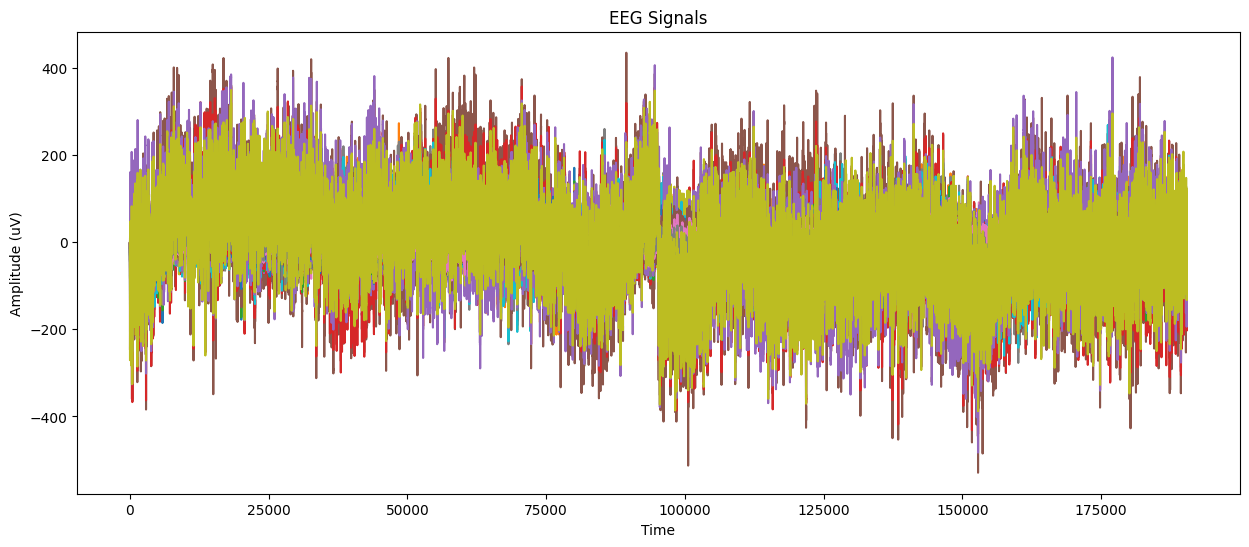

In [17]:
#Plotting the EEG Signals
# Load data from Matlab file
data = scipy.io.loadmat("BCICIV_calib_ds1d.mat")
cnt = data['cnt']
mrk = data['mrk']
pos = mrk['pos'][0][0]
y = mrk['y'][0][0]
nfo = data['nfo']
fs = nfo['fs'][0][0]
clab = [str(item[0]) for item in nfo['clab'][0][0][:, 0]]
# Convert cnt to microvolts
cnt = 0.1 * cnt.astype(np.float32)

plt.figure(figsize=(15, 6))
plt.plot(cnt)
plt.xlabel('Time')
plt.ylabel('Amplitude (uV)')
plt.title('EEG Signals')
plt.show()


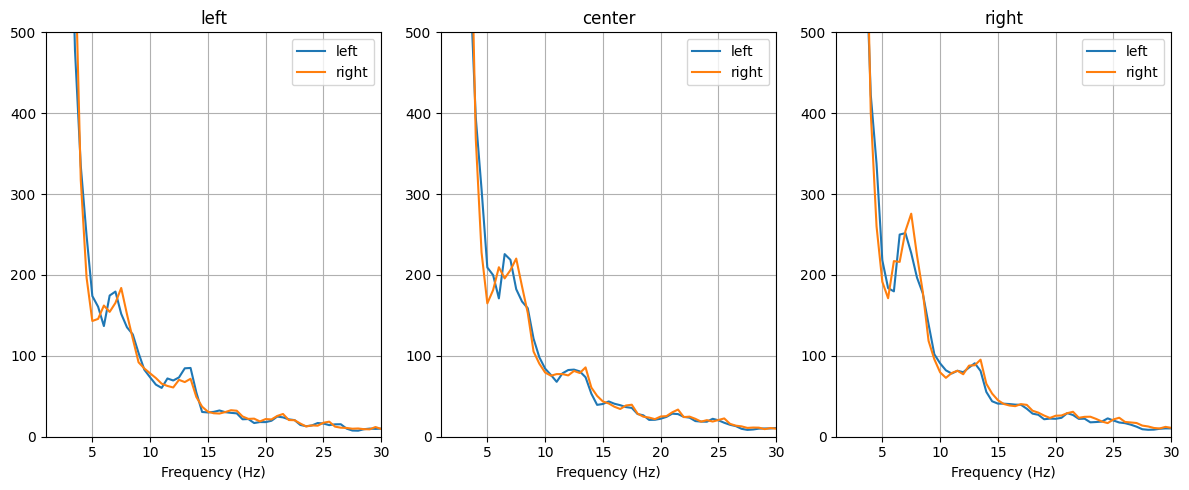

In [18]:
plot_psd(trials_PSD,freqs,
          [channelNames.index(ch) for ch in ['C3','Cz','C4']], 
          chanlab=['left','center','right'],maxy=500);

In [19]:
import scipy.signal
def bandpass(trials,lo,hi,sampleRate):
    '''Parameters:
    trials : 3d array (channels x samples x trials)
    lo : low frequency of passbandfr
    hi : high frequency of passband
    sampleRate : sampling frequency
    Data type is float
    Returns:
    3d array (channels x samples x trials)
    '''
    a,b=scipy.signal.iirfilter(6,[lo/(sampleRate/2.0),hi/(sampleRate/2.0)])
    # Apply the filter to each trial
    ntrials = trials.shape[2]
    trials_filt = np.zeros((nchannels,nsamples,ntrials))
    for i in range(ntrials):
        trials_filt[:,:,i] = scipy.signal.filtfilt(a,b,trials[:,:,i],axis=1)
    return trials_filt

In [20]:
# Bandpass filtering
trials_filt = {classLabel1:bandpass(trials[classLabel1],8,15,sampleRate),
               classLabel2: bandpass(trials[classLabel2],8,15,sampleRate)}

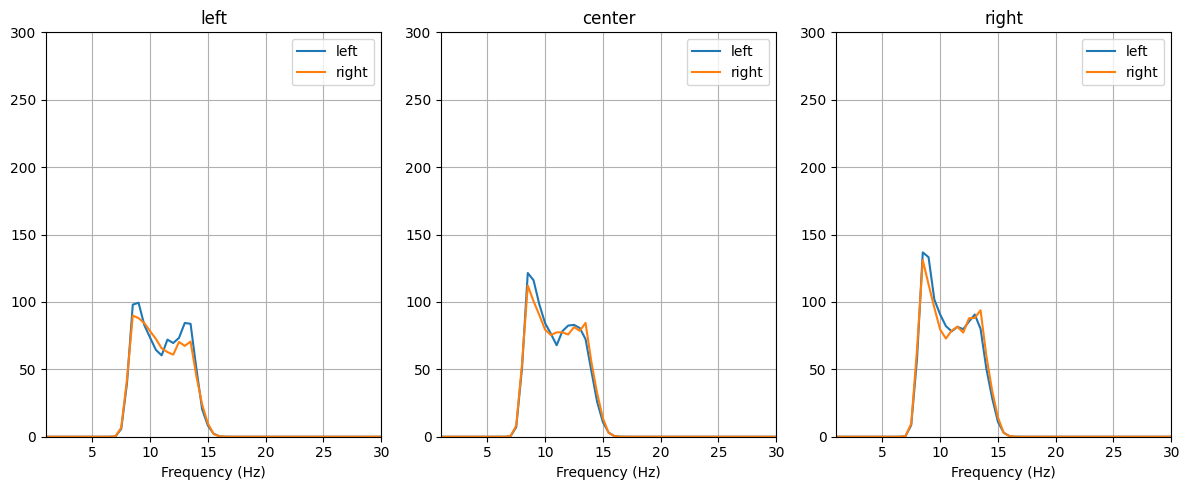

In [21]:
# Plotting the PSD of the filtered signal   
psd_r,freq = psd(trials_filt[classLabel1])
psd_f,freq = psd(trials_filt[classLabel2])
trials_PSD = {classLabel1: psd_r, classLabel2: psd_f}

plot_psd(trials_PSD, freq, [channelNames.index(ch) for ch in ['C3','Cz','C4']], chanlab = ['left', 'center', 'right'], maxy = 300)

In [22]:
# Calculating the log-variance of the trials
def logvar(trials):
    '''Parameters:
    trials : 3d array (channels x samples x trials)
    Returns:
    logvar: 2d array (channels x trials)
    '''
    return np.log(np.var(trials,axis=1))

In [23]:
# CALLING THE LOGVAR FUNCTION
trials_logvar = {classLabel1: logvar(trials_filt[classLabel1]),
                    classLabel2: logvar(trials_filt[classLabel2])}
# This will result in a single variable for each trial
trials_logvar['right'].shape
# 59: Number of channels
# 100: Number of trials

(59, 100)

In [24]:
# Visualizing the log-variance of the trials for each channel
def plot_logvar(trials):
    plt.figure(figsize=(12,5))
    
    x0=np.arange(nchannels)
    x1=x0+0.4

    y0 = np.mean(trials[classLabel1],axis=1)
    y1 = np.mean(trials[classLabel2],axis=1)

    plt.bar(x0,y0, width=0.5, color='b', label=classLabel1)
    plt.bar(x1,y1, width=0.5, color='r', label=classLabel2)

    plt.xlim(-0.5,nchannels+0.5)

    plt.gca().yaxis.grid(True)
    plt.title('Log-variance of the trials of each channel')
    plt.xlabel('Channels/component')
    plt.ylabel('Log-variance')
    plt.legend()

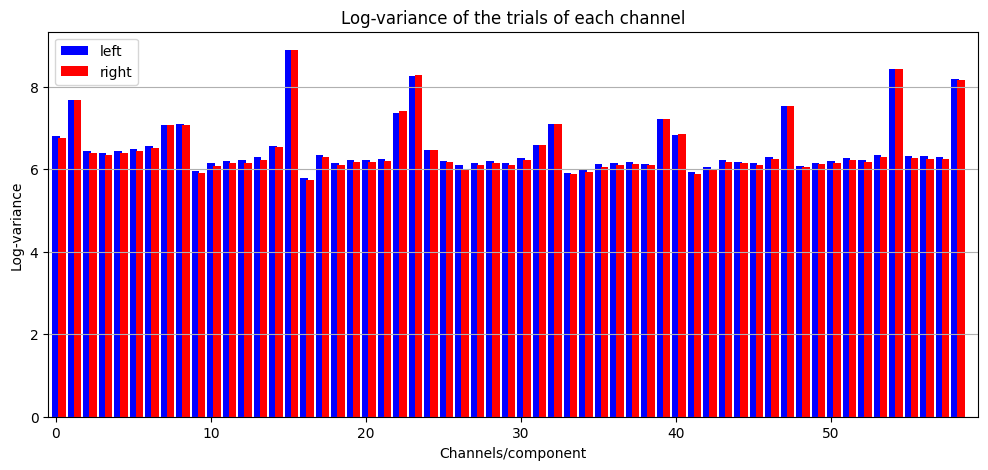

In [25]:
# Plotting log var chart
plot_logvar(trials_logvar)

In [26]:
# The difference between left and right is very minimum.
# We need to maximise the difference between the two classes.
# We will use the Common Spatial Pattern (CSP)
# CSP is a spatial filter that maximizes the variance of one class while minimizing the variance of the other.
# It is a supervised method, so it requires the labels of the trials.

from numpy import linalg
def cov(trials):
    '''Parameters:
    trials : 3d array (channels x samples x trials)
    Returns:
    Mean of covariance
    '''
    ntrials = trials.shape[2] # Number of trials
    covs = [trials[:,:,i].dot(trials[:,:,i].T)/nsamples for i in range(ntrials)] # List of covariances
    return np.mean(covs, axis=0)# Mean of covariances


In [27]:
# Calculating the whitening matrix for covariance matrix.
# The whitening matrix is the square root of the inverse of the covariance matrix.
# It will be used to whiten the data (i.e., make the covariance matrix the identity matrix)
#Sigma is the covariance matrix
def whitening(sigma):
    U, l, _ = linalg.svd(sigma)  # Singular Value Decomposition
    return U.dot(np.diag(l ** -0.5)) # Return the whitening matrix




In [28]:
#Calculating the CSP transformation matrix W
def csp(trials_r, trials_f):
    '''Parameters:
    trials_r : 3d array (channels x samples x trials) for right hand
    trials_f : 3d array (channels x samples x trials) for foot
    Returns:
    W: 2d array (channels x channels) Mixing matrix W
    '''
    cov_r = cov(trials_r) # Covariance matrices
    cov_f = cov(trials_f) # Covariance matrices
    P = whitening(cov_r + cov_f) # Whitening transformation matrix
    B, _, _= linalg.svd(P.T.dot(cov_f).dot(P)) # Singular Value Decomposition, _ indicates we don't need the third return value
    W = P.dot(B) # Common Spatial Patterns
    return W #Return the weight matrix which contains the spatial filters in its columns 
    #W is the spatial filter that maximizes the variance of one class while minimizing the variance of the other.



In [29]:
def apply_mix(W,trials):
    #Apply a mixing matrix to each trial
    #Multiply W with each trial
    ntrials = trials.shape[2]
    trials_csp = np.zeros((nchannels,nsamples,ntrials))
    for i in range(ntrials):
        trials_csp[:,:,i] = W.T.dot(trials[:,:,i])
    return trials_csp

In [30]:
#Apply the functions
W =csp(trials_filt[classLabel1],trials_filt[classLabel2])

trials_csp = {classLabel1:apply_mix(W,trials_filt[classLabel1]),
              classLabel2:apply_mix(W,trials_filt[classLabel2])}

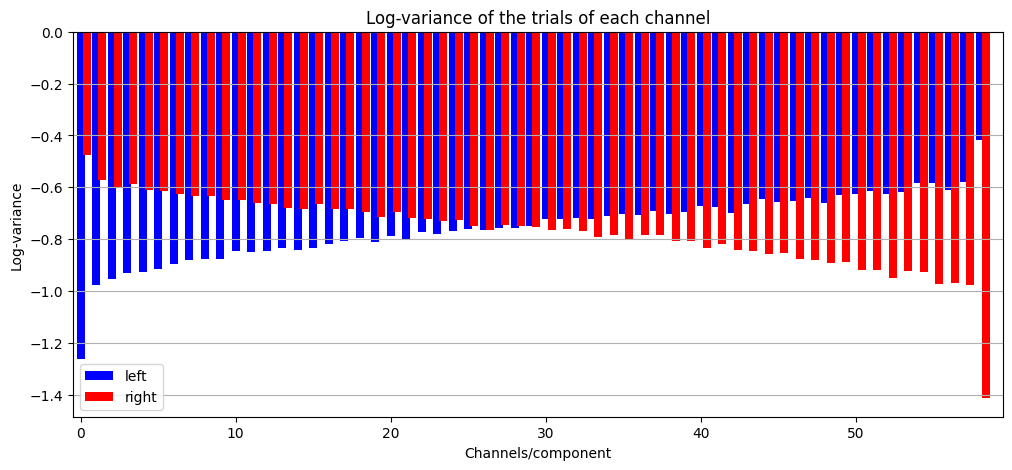

In [31]:
#Plotting the log var plot to see the CSP Algorithm result.
trials_logvar = {classLabel1: logvar(trials_csp[classLabel1]),
                 classLabel2: logvar(trials_csp[classLabel2])}
plot_logvar(trials_logvar)

In [32]:
#In the graph, we see that the difference between the two classes is maximized.
#We can now use the CSP features to train a classifier.
#We will use the log-variance of the CSP features as input to the classifier.


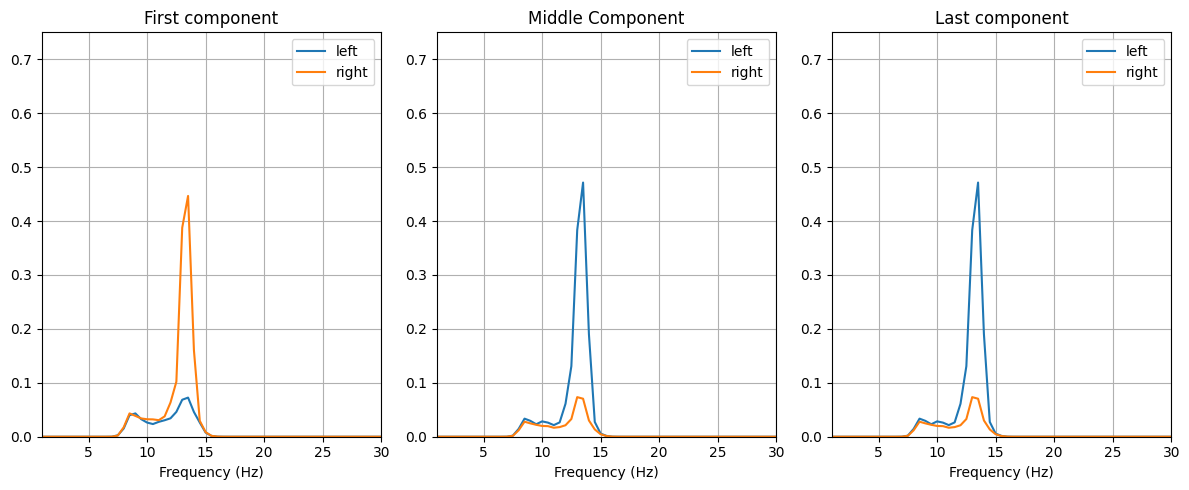

In [33]:
# Getting the Power Spectral Density of the CSP features
psd_r, freqs = psd(trials_csp[classLabel1])
psd_f, freqs = psd(trials_csp[classLabel2])
trials_PSD = {classLabel1: psd_r, classLabel2: psd_f}
plot_psd(trials_PSD,freqs,[0,58,-1],chanlab = ['First component','Middle Component', 'Last component'], maxy = 0.75)

In [34]:
# We can see that the CSP features have a clear separation between the two classes.
# Plotting the scatterplot of the CSP features
def plot_scatter(left,foot):
    plt.figure()
    plt.scatter(left[0,:],left[-1,:],c='b',label=classLabel1)
    plt.scatter(foot[0,:],foot[-1,:],c='r',label=classLabel2)
    plt.xlabel('Last Component')
    plt.ylabel('First Component')
    plt.legend()

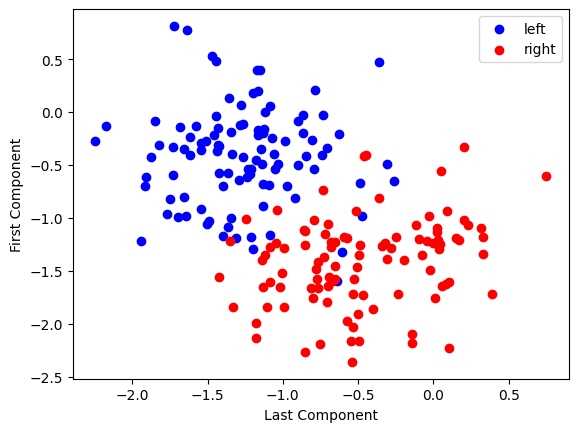

In [35]:
# Plotting the scatter plot
plot_scatter(trials_logvar[classLabel1],trials_logvar[classLabel2])
#This plot represents the log-variance of the CSP features before the classifier.

In [36]:
# Training the classifier using train and test data
train_percent = 0.8 # 80% of the data is used for training
ntrain_r = int(trials_filt[classLabel1].shape[2]*train_percent)# Number of trials for right hand in training set
#where trials_filt is the filtered signal of the trials
ntrain_f = int(trials_filt[classLabel2].shape[2]*train_percent)# Number of trials for left hand in training set

ntest_r = trials_filt[classLabel1].shape[2] - ntrain_r # Number of trials for right hand in test set
ntest_f = trials_filt[classLabel2].shape[2] - ntrain_f # Number of trials for foot in test set

#Splitting the frequency filtered data into training and test data
train = {classLabel1: trials_filt[classLabel1][:,:,:ntrain_r],
         classLabel2: trials_filt[classLabel2][:,:,:ntrain_f]}
#Here [:,:,:ntrain_r] means that we are taking all the channels, all the samples and ntrain_r number of trials for right hand
#and similarly for the foot.

test = {classLabel1: trials_filt[classLabel1][:,:,ntrain_r:],
        classLabel2: trials_filt[classLabel2][:,:,ntrain_f:]}
#Here [:,:,ntrain_r:] means that we are taking all the channels, all the samples and ntrain_r number of trials for right hand



In [37]:
#Training the CSP on the training set only
W = csp(train[classLabel1],train[classLabel2])
W.shape
#(59, 59) meean 59 channels and 59 components of the CSP features are extracted from each signal (each signal is composed of 59 channels)


(59, 59)

In [38]:
train[classLabel1].shape
#(59, 100, 50) means 59 channels, 100 samples and 50 trials for right hand


(59, 200, 80)

In [39]:
# Applying CSP on both training and test data
train[classLabel1] = apply_mix(W,train[classLabel1])    
train[classLabel2] = apply_mix(W,train[classLabel2])
test[classLabel1] = apply_mix(W,test[classLabel1])
test[classLabel2] = apply_mix(W,test[classLabel2])

train[classLabel1].shape

(59, 200, 80)

In [40]:
#Selecting only the first and last component of the CSP features to train the classifier
#The first and last component are selected because they are the most discriminative components
comp = np.array([0,-1])  #First and Last Component
train[classLabel1] =train[classLabel1][comp, :,:]
train[classLabel2] =train[classLabel2][comp, :,:]
test[classLabel1] =test[classLabel1][comp, :,:]
test[classLabel2] =test[classLabel2][comp, :,:]

train[classLabel1].shape
#(2, 50, 50) means 2 components, 50 samples and 50 trials for right hand
#Component means the CSP features extracted from the signal using a specific frequency band


(2, 200, 80)

In [41]:
#Applying the log-variance to the CSP features to  train the classifier
train[classLabel1] = logvar(train[classLabel1])
train[classLabel2] = logvar(train[classLabel2])
test[classLabel1] = logvar(test[classLabel1])
test[classLabel2] = logvar(test[classLabel2])
train[classLabel1].shape
#(2, 50) means 2 components and 50 trials for right hand.
#We have 50 trials for right hand and 50 trials for foot.

(2, 80)

In [42]:
train[classLabel1].T
#We have 50 trials and 2 components.
# These are the features that we will use to train the classifier.


array([[-1.69473597, -0.34137003],
       [-1.19046482, -0.06432186],
       [-1.4916221 ,  0.11338291],
       [-0.93406197, -0.52816111],
       [-0.70177132, -0.2627317 ],
       [-0.31523172, -0.68581172],
       [-0.48672262,  0.42796893],
       [-1.07512736, -0.50421744],
       [-1.33625978, -0.2560672 ],
       [-1.75533772,  0.8086255 ],
       [-1.64498575, -0.75598381],
       [-1.62188422, -0.15865297],
       [-1.14056873,  0.04664113],
       [-1.7161249 , -0.14602641],
       [-1.72570716, -0.87289316],
       [-1.61044932, -0.99557973],
       [-2.38298872, -0.28225799],
       [-0.45250851, -1.00520336],
       [-1.4797032 ,  0.42730973],
       [-1.44725635, -0.18901526],
       [-0.70754812, -1.57251408],
       [-1.26313275, -0.38540003],
       [-1.21236217,  0.10998591],
       [-0.85175724, -0.23733252],
       [-1.04051379, -0.72238566],
       [-0.91240075,  0.19502779],
       [-1.05666101, -0.01613729],
       [-1.02212038, -0.28089415],
       [-0.39461391,

In [43]:
#For a binary classification problem, we will use the Linear Discriminant Analysis (LDA) classifier.
#LDA is a simple and effective classifier for two classes. It fits a Gaussian distribution to each class, and then uses the distribution to predict the class of a new sample,
#characterized by the mean and covariance of each class and determines an optimal separating hyperplane.

def train_lda(class1,class2):
    '''Trains the LDA Algorithm
    Parameters:
    class1 : 2d array (observations x features) for class 1
    class2 : 2d array (observations x features) for class 2
    returns:
    The projection matrix W
    The offset b
    '''
    nclasses = 2
    nclass1 = class1.shape[0] # Number of observations for class 1
    nclass2 = class2.shape[0] # Number of observations for class 2

    #Class Priors : in this case both classes have the same number of observations
    # so both priors  are 0.5
    prior1 = nclass1/float(nclass1+nclass2)
    prior2 = nclass2/float(nclass1+nclass2)

    mean1 = np.mean(class1,axis=0) #Mean of class 1
    mean2 = np.mean(class2,axis=0) #Mean of class 2
    #Mean is required to calculate the covariance matrix
    class1_centered = class1 - mean1 #Center the data
    class2_centered = class2 - mean2 #Center the data

    #Within class covariance
    cov1 = class1_centered.T.dot(class1_centered)/(nclass1-nclasses)
    cov2 = class2_centered.T.dot(class2_centered)/(nclass2-nclasses)

    W = (mean2-mean1).dot(np.linalg.pinv(prior1*cov1+prior2*cov2)) #Projection matrix
    #This indicates the direction of the line that separates the two classes
    b = (prior1*mean1 + prior2*mean2).dot(W) #Offset which meabs the distance of the line from the origin

    return (W,b)



In [44]:
#Applying the previously trained LDA to the new data
#Arguments:
#W: Projection matrix
#b: Offset
#data: 2d array (observations x features)
#Returns:
#The predicted class of the data

def apply_lda(test, W, b):
    ntrials = test.shape[1]
    prediction=[]
    for i in range(ntrials):
        #This line below is the generalization for
        # result = W[0]*test[0,i] + W[1]*test[1,i] - b
        result = W.dot(test[:,i]) - b
        if result<=0:
            prediction.append(1)
        else:
            prediction.append(2)
    return np.array(prediction)

In [45]:
W,b = train_lda(train[classLabel1].T,train[classLabel2].T)
print("W:", W)
print("b:", b)




W: [ 5.0618314  -5.18758596]
b: 0.2893142369099939


Text(0.5, 1.0, 'Scatter plot of the training data ')

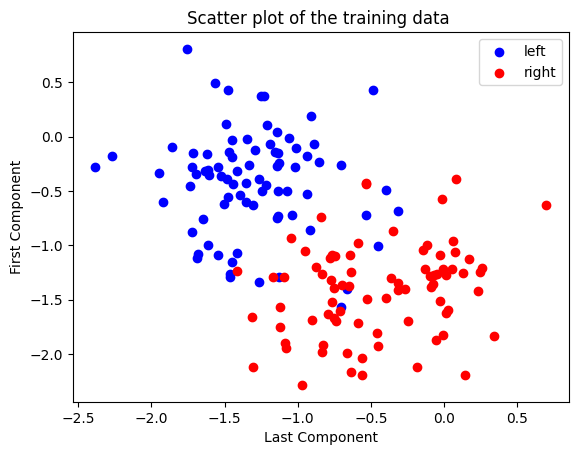

In [46]:
#Calculating the descision boundary of the classifier with the training data and plotting the decision boundary

#Scatterplot before
plot_scatter(train[classLabel1],train[classLabel2])
plt.title('Scatter plot of the training data ')

Text(0.5, 1.0, 'Scatter plot of the training data ')

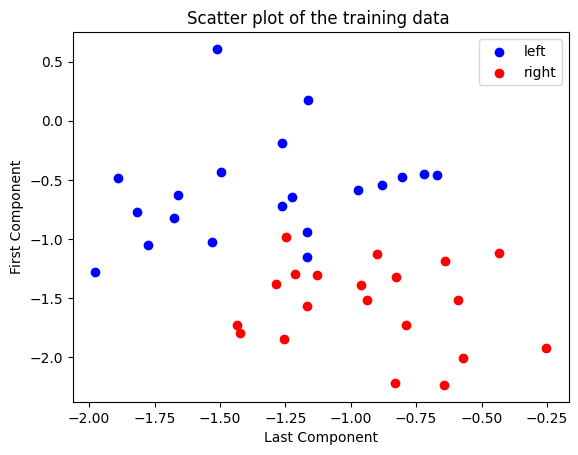

In [47]:
plot_scatter(test[classLabel1],test[classLabel2])
plt.title('Scatter plot of the training data ')

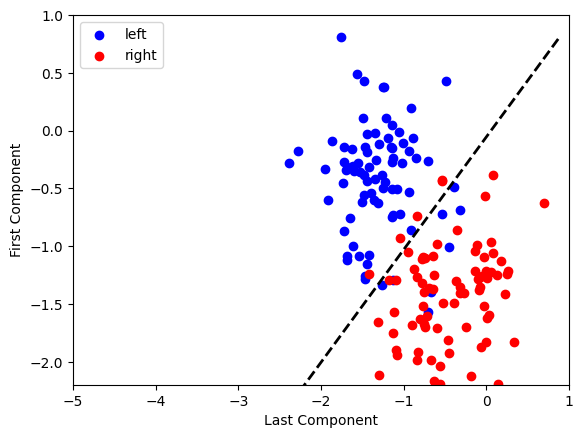

In [48]:
# Training the LDA classifier using the training data
# W, b = train_lda(train[classLabel1].T, train[classLabel2].T)

# Plotting the scatter plot
plot_scatter(train[classLabel1], train[classLabel2])

# Calculating the decision boundary
x = np.arange(-5, 1, 0.1)
y = (b - W[0] * x) / W[1]  # Calculate the decision boundary using LDA parameters

# Plotting the decision boundary
plt.plot(x, y, linestyle='--', linewidth=2, color='k')
plt.xlim(-5, 1)
plt.ylim(-2.2, 1)
plt.show()


(-2.2, 1.0)

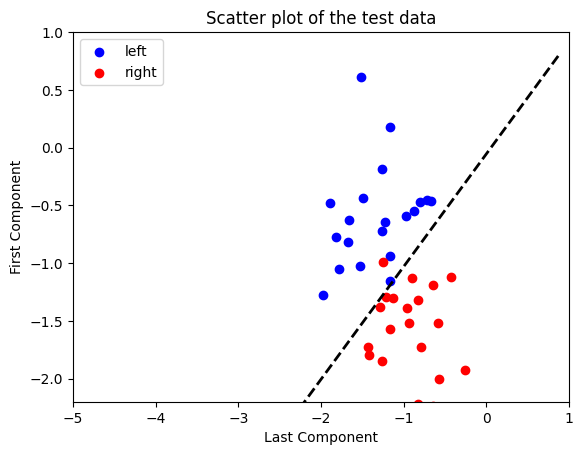

In [49]:
#Applying the classifier on the test data
plot_scatter(test[classLabel1],test[classLabel2])
plt.title('Scatter plot of the test data')
plt.plot(x,y,linestyle='--',linewidth=2 ,color='k')
plt.xlim(-5,1)
plt.ylim(-2.2,1) #-2.2,1 means the range of the y-axis is from -2.2 to 1


In [50]:
#We can see that the decision boundary separates the two classes. But some of the points are misclassified.
#Printing the confusion matrix and the accuracy of the classifier
#The confusion matrix is a table used to describe the performance of a classification model
#The confusion matrix shows the ways in which the classification model is confused when it makes predictions.
#It gives us insight not only into the errors being made by a classifier but more importantly the types of errors that are being made.
#The confusion matrix is a 2x2 matrix, because we have two classes.
#The rows represent the actual class and the columns represent the predicted class.
#The diagonal elements represent the number of points that are correctly classified.
#The off-diagonal elements represent the number of points that are misclassified.
#The accuracy is the ratio of the number of correctly classified points to the total number of points.
#The accuracy is a measure of the classifier's performance.
conf = np.array([
    [(apply_lda(test[classLabel1],W,b)==1).sum(), (apply_lda(test[classLabel2],W,b)==1).sum()],
    [(apply_lda(test[classLabel1],W,b)==2).sum(), (apply_lda(test[classLabel2],W,b)==2).sum()]
])
print('Confusion Matrix:')
print(conf)
print('Accuracy: %.3f' % (np.sum(np.diag(conf)) / float(np.sum(conf))))



Confusion Matrix:
[[20  1]
 [ 0 19]]
Accuracy: 0.975


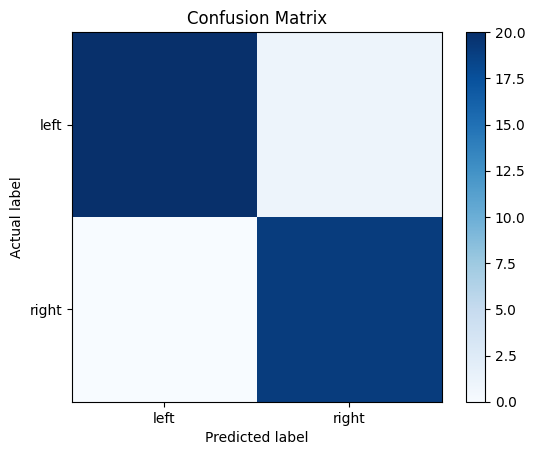

In [51]:
# Plotting the confusion matrix
plt.figure()
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, [classLabel1, classLabel2])
plt.yticks(tick_marks, [classLabel1, classLabel2])
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


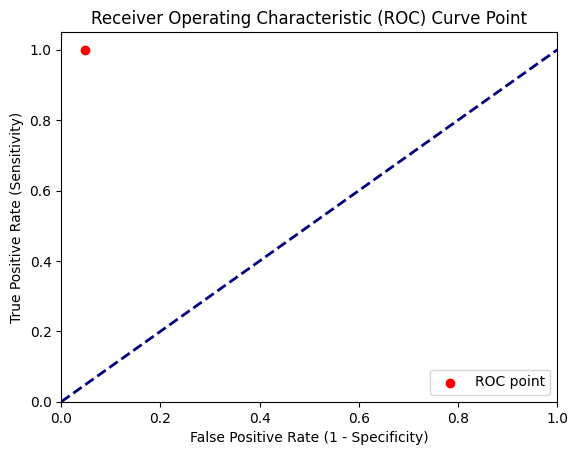

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Confusion matrix
conf_matrix = np.array([[20, 1],
                        [0, 19]])

# True positive, false positive, true negative, false negative
TP = conf_matrix[1, 1]
FP = conf_matrix[0, 1]
TN = conf_matrix[0, 0]
FN = conf_matrix[1, 0]

# Sensitivity (true positive rate)
sensitivity = TP / (TP + FN)

# Specificity (true negative rate)
specificity = TN / (TN + FP)

# Plotting ROC point
plt.figure()
plt.scatter(1 - specificity, sensitivity, c='r', label='ROC point')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve Point')
plt.legend(loc="lower right")
plt.show()
